### INF 385: Lecture 11
Basically just a reproduction of Grus' toy collaborative filtering examples

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import math, random
from collections import defaultdict, Counter

In [2]:
###
# example from Joel Grus (Data Science From Scratch)
users_interests = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

unique_interests = sorted(list({ interest
                                 for user_interests in users_interests
                                 for interest in user_interests }))

def make_user_interest_vector(user_interests):
    """given a list of interests, produce a vector whose i-th element is 1
    if unique_interests[i] is in the list, 0 otherwise"""
    return [1 if interest in user_interests else 0
            for interest in unique_interests]

# essentially, a `bag of interests'
user_interest_matrix = list(map(make_user_interest_vector, users_interests))

In [5]:
unique_interests

['Big Data',
 'C++',
 'Cassandra',
 'HBase',
 'Hadoop',
 'Haskell',
 'Java',
 'Mahout',
 'MapReduce',
 'MongoDB',
 'MySQL',
 'NoSQL',
 'Postgres',
 'Python',
 'R',
 'Spark',
 'Storm',
 'artificial intelligence',
 'databases',
 'decision trees',
 'deep learning',
 'libsvm',
 'machine learning',
 'mathematics',
 'neural networks',
 'numpy',
 'pandas',
 'probability',
 'programming languages',
 'regression',
 'scikit-learn',
 'scipy',
 'statistics',
 'statsmodels',
 'support vector machines',
 'theory']

In [4]:
print(np.matrix(user_interest_matrix[:2]))

[[1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


In [6]:
def cosine_similarity(v, w):
    return np.dot(v, w) / math.sqrt(np.dot(v, v) * np.dot(w, w))

In [7]:
user_similarities = [[cosine_similarity(interest_vector_i, interest_vector_j)
                      for interest_vector_j in user_interest_matrix]
                     for interest_vector_i in user_interest_matrix]

In [8]:
np.matrix(user_similarities).shape

(15, 15)

In [9]:
np.matrix(user_similarities)[0,:]

matrix([[ 1.        ,  0.3380617 ,  0.        ,  0.        ,  0.        ,
          0.15430335,  0.        ,  0.        ,  0.18898224,  0.56694671,
          0.        ,  0.        ,  0.        ,  0.16903085,  0.        ]])

In [10]:
def most_similar_users_to(user_id):
    pairs = [(other_user_id, similarity)                      # find other
             for other_user_id, similarity in                 # users with
                enumerate(user_similarities[user_id])         # nonzero
             if user_id != other_user_id and similarity > 0]  # similarity

    return sorted(pairs,                                      # sort them
                  key=lambda pair: pair[1],                   # most similar
                  reverse=True)                               # first



    

In [11]:
most_similar_users_to(0)

[(9, 0.56694670951384085),
 (1, 0.33806170189140661),
 (8, 0.1889822365046136),
 (13, 0.1690308509457033),
 (5, 0.15430334996209191)]

In [12]:
def user_based_suggestions(user_id, include_current_interests=False):
    # sum up the similarities
    suggestions = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
        for interest in users_interests[other_user_id]:
            suggestions[interest] += similarity

    # convert them to a sorted list
    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[1],
                         reverse=True)

    # and (maybe) exclude already-interests
    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]

In [13]:
# recall that we know that user 0 likes: 
#    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"]
print(user_based_suggestions(0))

[('MapReduce', 0.56694670951384085), ('MongoDB', 0.50709255283710997), ('Postgres', 0.50709255283710997), ('NoSQL', 0.33806170189140661), ('neural networks', 0.1889822365046136), ('deep learning', 0.1889822365046136), ('artificial intelligence', 0.1889822365046136), ('databases', 0.1690308509457033), ('MySQL', 0.1690308509457033), ('R', 0.15430334996209191), ('programming languages', 0.15430334996209191), ('Haskell', 0.15430334996209191), ('C++', 0.15430334996209191), ('Python', 0.15430334996209191)]


Use SVD to reduce dimensionality and, in theory, mitigate sparsity issues 

In [32]:
R = np.matrix(user_interest_matrix).T
U, s, V = np.linalg.svd(R, full_matrices=False)
# make S into a diagonal matrix
S = np.diag(s)

k = 2
R_reconstructed = np.dot(U, np.dot(S, V)).T
R_reconstructed.shape

(15, 36)

In [33]:
R_reduced = np.dot(U[:k], np.dot(S[:k].T, V[:k])).T
R_reduced.shape

(15, 2)

user: 0. interests -- ['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
user: 1. interests -- ['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
user: 2. interests -- ['Python', 'scikit-learn', 'scipy', 'numpy', 'statsmodels', 'pandas']
user: 3. interests -- ['R', 'Python', 'statistics', 'regression', 'probability']
user: 4. interests -- ['machine learning', 'regression', 'decision trees', 'libsvm']
user: 5. interests -- ['Python', 'R', 'Java', 'C++', 'Haskell', 'programming languages']
user: 6. interests -- ['statistics', 'probability', 'mathematics', 'theory']
user: 7. interests -- ['machine learning', 'scikit-learn', 'Mahout', 'neural networks']
user: 8. interests -- ['neural networks', 'deep learning', 'Big Data', 'artificial intelligence']
user: 9. interests -- ['Hadoop', 'Java', 'MapReduce', 'Big Data']
user: 10. interests -- ['statistics', 'R', 'statsmodels']
user: 11. interests -- ['C++', 'deep learning', 'artificial intelligence', 'probability']
user: 

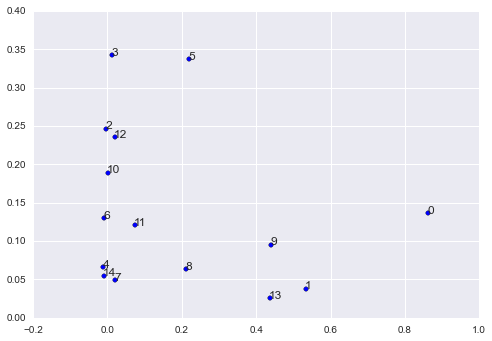

In [34]:
fig, ax = plt.subplots()
ax.scatter(R_reduced[:,0], R_reduced[:,1])

# add the user ids
for user_index in range(R_reduced.shape[0]):
    print("user: %s. interests -- %s" % (user_index, users_interests[user_index]))
    ax.annotate(str(user_index), R_reduced[user_index].tolist()[0]);

In [ ]:
print(users_interests)

### Now let's consider *item*-based collaborative filtering

In [35]:
#
# Item-Based Collaborative Filtering
#
interest_user_matrix = [[user_interest_vector[j]
                         for user_interest_vector in user_interest_matrix]
                        for j, _ in enumerate(unique_interests)]

interest_similarities = [[cosine_similarity(user_vector_i, user_vector_j)
                          for user_vector_j in interest_user_matrix]
                         for user_vector_i in interest_user_matrix]

def most_similar_interests_to(interest_id):
    similarities = interest_similarities[interest_id]
    pairs = [(unique_interests[other_interest_id], similarity)
             for other_interest_id, similarity in enumerate(similarities)
             if interest_id != other_interest_id and similarity > 0]
    return sorted(pairs,
                  key=lambda pair: pair[1],
                  reverse=True)

def item_based_suggestions(user_id, include_current_interests=False):
    suggestions = defaultdict(float)
    user_interest_vector = user_interest_matrix[user_id]
    for interest_id, is_interested in enumerate(user_interest_vector):
        if is_interested == 1:
            similar_interests = most_similar_interests_to(interest_id)
            for interest, similarity in similar_interests:
                suggestions[interest] += similarity

    suggestions = sorted(suggestions.items(),
                         key=lambda pair: pair[1],
                         reverse=True)

    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight)
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]


In [ ]:
print("Item based similarity")
print("most similar to 'Big Data'")
print(most_similar_interests_to(0))
print()

In [ ]:
print("suggestions for user 0")
print(item_based_suggestions(0))

### Using modern kit (i.e., not from scratch)
credit for most of the code here goes to [Ethan Rosenthal](http://blog.ethanrosenthal.com/), who has posted a very nice tutorial here: http://blog.ethanrosenthal.com/2015/11/02/intro-to-collaborative-filtering/

data available at: http://files.grouplens.org/datasets/movielens/ml-100k.zip

In [14]:
names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('ml-100k/u.data', sep='\t', names=names)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [15]:
n_users = df.user_id.unique().shape[0]
print("n users: %s" % n_users)
n_items = df.item_id.unique().shape[0]
print("n items: %s" % n_items)

n users: 943
n items: 1682


Now we want to construct a user-item matrix

In [16]:
ratings = np.zeros((n_users, n_items))
for row in df.itertuples():
    # row[1] will the user_id; row[2] the 
    # rating (see also my note below).
    # the -1 is to move to 0 indexing.
    ratings[row[1]-1, row[2]-1] = row[3]
ratings

array([[ 5.,  3.,  4., ...,  0.,  0.,  0.],
       [ 4.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 5.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  5.,  0., ...,  0.,  0.,  0.]])

In [17]:
# (aside: if the above seems mystifying, look at what 
#   itertuples does -- it just let's us walk over the
#   rows in a dataframe; let's inspect the first element)
list(df.itertuples())[0]

(0, 196, 242, 3, 881250949)

How sparse is our matrix? (i.e., how many zero entries?)

In [18]:
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('sparsity: {:4.2f}%'.format(sparsity))

sparsity: 6.30%


In [19]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        ###
        # sample 10 ratings from each user to use
        # as 'test' data
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        # effectively remove these from the training
        # set
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # make sure that test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    
    return train, test

In [20]:
train, test = train_test_split(ratings)

In [25]:
def similarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
        print(sim)
    elif kind == 'item':
        # we need only flip the dimensions around 
        # to do item based similarity!
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / (norms * norms.T))

the above probably looks more intimadating then it needs to -- let's work through the similarity function on the board

In [26]:
user_similarity = similarity(train, kind='user')
item_similarity = similarity(train, kind='item')

[[ 3803.   212.    48. ...,   125.   369.  1120.]
 [  212.   750.    75. ...,    39.   177.   126.]
 [   48.    75.   408. ...,    28.   103.    16.]
 ..., 
 [  125.    39.    28. ...,   202.    36.    67.]
 [  369.   177.   103. ...,    36.  1310.   252.]
 [ 1120.   126.    16. ...,    67.   252.  2138.]]


In [27]:
sim = ratings.dot(train.T) + 1e-9
sim

array([[ 3803.,   212.,    48., ...,   125.,   369.,  1129.],
       [  319.,   750.,    75., ...,    55.,   185.,   151.],
       [   67.,    75.,   408., ...,    28.,   103.,    16.],
       ..., 
       [  170.,    79.,    44., ...,   202.,    56.,    67.],
       [  436.,   193.,   115., ...,    56.,  1310.,   300.],
       [ 1174.,   126.,    28., ...,    87.,   283.,  2138.]])

In [29]:
def predict(ratings, similarity, kind='user'):
    if kind == 'user':
        return similarity.dot(ratings) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif kind == 'item':
        return ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [30]:
def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [31]:
item_prediction = predict(train, item_similarity, kind='item')
user_prediction = predict(train, user_similarity, kind='user')

print('User-based CF MSE: ' + str(get_mse(user_prediction, test)))
print('Item-based CF MSE: ' + str(get_mse(item_prediction, test)))

User-based CF MSE: 8.40365827368
Item-based CF MSE: 11.550496268


Idea: Top-$k$ filtering: only consider $u$' such that $u$' is amongst top $k$ neighbors to $u$

In [37]:
def predict_topk(ratings, similarity, kind='user', k=40):
    pred = np.zeros(ratings.shape)
    
    for i in range(ratings.shape[0]):
        # note! the [::-1] craziness is just a numpy trick to 
        # reverse the array. we're doing this because otherwise
        # it is sorted in the direction opposite of what we want
        # -- lowest to highest, so least to most similar. 
        # we flip this around then take the top k.
        top_k_users =  np.argsort(similarity[:,i])[::-1][:k] #[np.argsort(similarity[:,i])[:-k-1:-1]]
        
        for j in range(ratings.shape[1]):
            pred[i, j] = similarity[i, :][top_k_users].dot(ratings[:, j][top_k_users]) 
            pred[i, j] /= np.sum(np.abs(similarity[i, :][top_k_users]))

    return pred


In [38]:
pred = predict_topk(train, user_similarity, k=40)
print('Top-k User-based CF MSE: ' + str(get_mse(pred, test)))


Top-k User-based CF MSE: 6.4913559547


So that helps! Let's explore different $k$

In [39]:
k_array = [5, 15, 30, 50, 100, 200]
user_train_mse = []
user_test_mse = []
item_test_mse = []
item_train_mse = []

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

for k in k_array:
    user_pred = predict_topk(train, user_similarity, k=k)
    
    user_train_mse += [get_mse(user_pred, train)]
    user_test_mse += [get_mse(user_pred, test)]
    

Now visualize these results

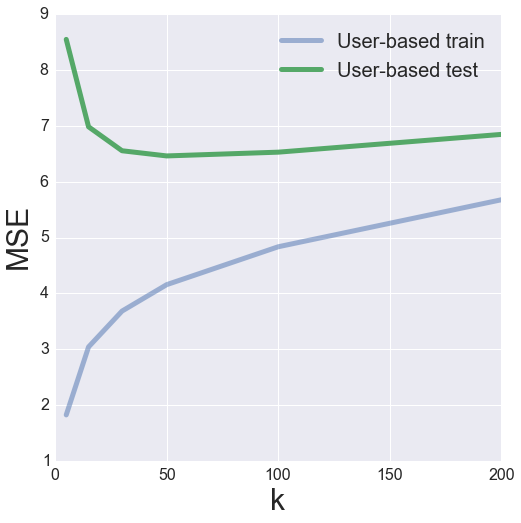

In [40]:
pal = sns.color_palette("Set2", 2)

plt.figure(figsize=(8, 8))
plt.plot(k_array, user_train_mse, c=pal[0], label='User-based train', alpha=0.5, linewidth=5)
plt.plot(k_array, user_test_mse, c=pal[0], label='User-based test', linewidth=5)

plt.legend(loc='best', fontsize=20)
plt.xticks(fontsize=16);
plt.yticks(fontsize=16);
plt.xlabel('k', fontsize=30);
plt.ylabel('MSE', fontsize=30);

See more at: http://blog.ethanrosenthal.com/!